# Combined LLM + Human Agent

**Note:**
<div class="alert alert-block alert-info">

1. This notebook presents the output of the combined 3 LLMs (GPT4, Gemini Advanced, and Claude) with human intervention. From each of the individual LLM output recorded in the other notebooks, we manually combine the output into one single running code, taking the best combination of output.
2. Human added touch has also been introduced to further improved the analytics on top of what the LLM offers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import seaborn.objects as so

from scipy import stats
from scipy.stats import zscore
from scipy.stats.contingency import association

from sklearn.preprocessing import LabelEncoder

from loguru import logger
from omegaconf import OmegaConf

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

### Load Dataset

**Prompt:**
<div class="alert alert-block alert-info">
Here is the dataset hotel_reservation.csv

`import`
</div>

**Note:**
<div class="alert alert-warning">

1. The above is the prompt for GPT4 for which we are able to upload the full dataset.
2. For Gemini Advanced and Claude, we upload the first 20 rows of data due to the limitation. Although we are aware that by using third party provider such as `poe.com` would allow us to potentially upload dataset, we decide to stick with the official LLM website `https://gemini.google.com/` and `https://claude.ai/`
</div>

In [2]:
data = pd.read_csv('../../data/raw/hotel_reservations.csv')
data

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


### Basic Checks

**Prompt:**
<div class="alert alert-block alert-info">
Before we proceed, let me share the metadata for the dataset.
</div>

   #### Dataset Source:
   https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

   #### DBA4714 Deep Learning and Generative AI in Business
   Revenue Management in Hotel Reservations

   #### Problem Statement
   The online hotel reservation channels have dramatically changed booking possibilities and customers’ behavior. A significant number of hotel reservations are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with.

The file contains the different attributes of customers' reservation details. The detailed data dictionary is given below.

   #### Train data:
| No. | Features | Description |
| :-------- | :-------- | :-------- |
| 1. | Booking_ID | Unique identifier of each booking |
| 2. | no_of_adults | Number of adults |
| 3. | no_of_children | Number of Children |
| 4. | no_of_weekend_nights | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| 5. | no_of_week_nights | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| 6. | type_of_meal_plan | Type of meal plan booked by the customer |
| 7. | required_car_parking_space | Does the customer require a car parking space? (0 - No, 1- Yes) |
| 8. | room_type_reserved | Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels. |
| 9. | lead_time | Number of days between the date of booking and the arrival date |
| 10. | arrival_year | Year of arrival date |
| 11. | arrival_month | Month of arrival date |
| 12. | arrival_date | Date of the month |
| 13. | market_segment_type | Market segment designation |
| 14. | repeated_guest | Is the customer a repeated guest? (0 - No, 1- Yes) |
| 15. | no_of_previous_cancellations | Number of previous bookings that were canceled by the customer prior to the current bookinge |
| 16. | no_of_previous_bookings_not_canceled | Number of previous bookings not canceled by the customer prior to the current booking |
| 17. | avg_price_per_room | Average price per day of the reservation; prices of the rooms are dynamic. (in euros) |
| 18. | no_of_special_requests | Total number of special requests made by the customer (e.g. high floor, view from the room, etc) |
| 19. | booking_status | Flag indicating if the booking was canceled or not |

**Prompt:**
<div class="alert alert-block alert-info">

For the first portion of the project, the plan is to conduct Exploratory Data Analysis. Firstly, please help me conduct a data quality check.
</div>

In [3]:
print(data.shape)

(36275, 19)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [5]:
data.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


### Identifying Missing Values

In [6]:
print(data.isnull().sum())

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64


**Note:**
1. There are no missing values in the dataset.

### Data Type Consistency

In [7]:
data.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

### Check for Duplicates

In [8]:
print(data.duplicated().sum())  # Counts duplicated rows

0


### Understanding target distribution

In [9]:
total_bookings = len(data)
canceled_bookings = sum(data['booking_status'] == 'Canceled')
cancellation_rate = (canceled_bookings / total_bookings) * 100

print(f"Overall Cancellation Rate: {cancellation_rate:.2f}%")

Overall Cancellation Rate: 32.76%


**Note:**
1. Overall cancellation rate is about 1/3 of the entire dataset.
2. This could potentially suggest data imbalances which we may or may not need to further address in order to build a robust predictive model.

**Prompt:**
<div class="alert alert-block alert-info">
Next, please perform univariate analysis on the dataset using the appropriate visualisation technique.
</div>

### Understanding unique values

In [10]:
# Check for invalid or abnormal values in categorical columns
categorical_cols = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
                    'market_segment_type', 'booking_status']

for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(data[col].unique())


Unique values in type_of_meal_plan:
['Meal Plan 1' 'Not Selected' 'Meal Plan 2' 'Meal Plan 3']

Unique values in required_car_parking_space:
[0 1]

Unique values in room_type_reserved:
['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']

Unique values in market_segment_type:
['Offline' 'Online' 'Corporate' 'Aviation' 'Complementary']

Unique values in booking_status:
['Not_Canceled' 'Canceled']


1. There seems to be no signs of abnormal categorical values from the columns from this quick view.

### Identifying Outliers

**Prompt:**
<div class="alert alert-block alert-info">
Let's delve deeper into exploratory data analysis. How do I perform outlier analysis for my features?
</div>

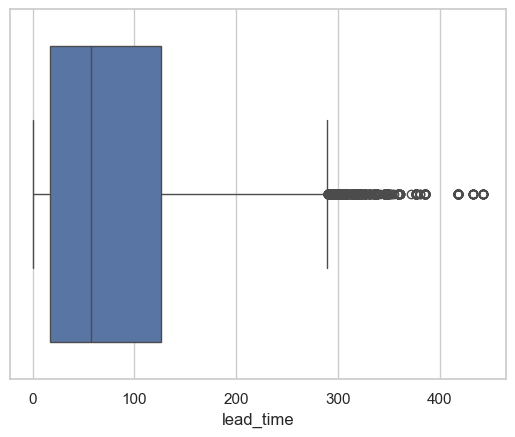

In [11]:
sns.boxplot(x = 'lead_time', data=data)
plt.show()

In [12]:
data['lead_time_z_score'] = zscore(data['lead_time'])
outliers = data[abs(data['lead_time_z_score']) > 3]
outliers

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,lead_time_z_score
5,INN00006,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,2018,9,13,Online,0,0,0,115.00,1,Canceled,3.034663
118,INN00119,2,0,0,1,Meal Plan 1,0,Room_Type 1,443,2018,4,29,Online,0,0,0,65.00,0,Canceled,4.163493
199,INN00200,2,0,1,2,Meal Plan 2,0,Room_Type 1,418,2018,9,26,Online,0,0,0,107.00,0,Canceled,3.872558
205,INN00206,2,0,0,3,Meal Plan 1,0,Room_Type 1,433,2018,9,8,Online,0,0,0,70.00,0,Canceled,4.047119
369,INN00370,2,0,2,0,Meal Plan 2,0,Room_Type 1,386,2018,10,23,Online,0,0,0,115.00,1,Canceled,3.500160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35594,INN35595,2,0,1,2,Meal Plan 2,0,Room_Type 1,418,2018,9,26,Offline,0,0,0,107.00,0,Canceled,3.872558
35630,INN35631,2,0,3,7,Meal Plan 1,0,Room_Type 4,351,2018,12,23,Online,0,0,0,85.85,3,Not_Canceled,3.092850
35656,INN35657,2,0,0,1,Meal Plan 1,0,Room_Type 1,443,2018,4,29,Offline,0,0,0,65.00,0,Canceled,4.163493
36006,INN36007,2,0,0,2,Meal Plan 2,0,Room_Type 1,377,2018,10,14,Offline,0,0,0,115.00,1,Canceled,3.395423


**Note:**
1. Here, using the z-score statistical method, we attempted to identify potential outlier in one of the numerical feature, namely, lead_time. Arbitrarily setting z-score to be greater than 3, we notice there are about 376 records which is categorised as outliers. However, business context points us to potentially leave these data points as they are instead of dropping them as hotel booking could technically be done a year in advance.

**Looking further into other numerical features...**

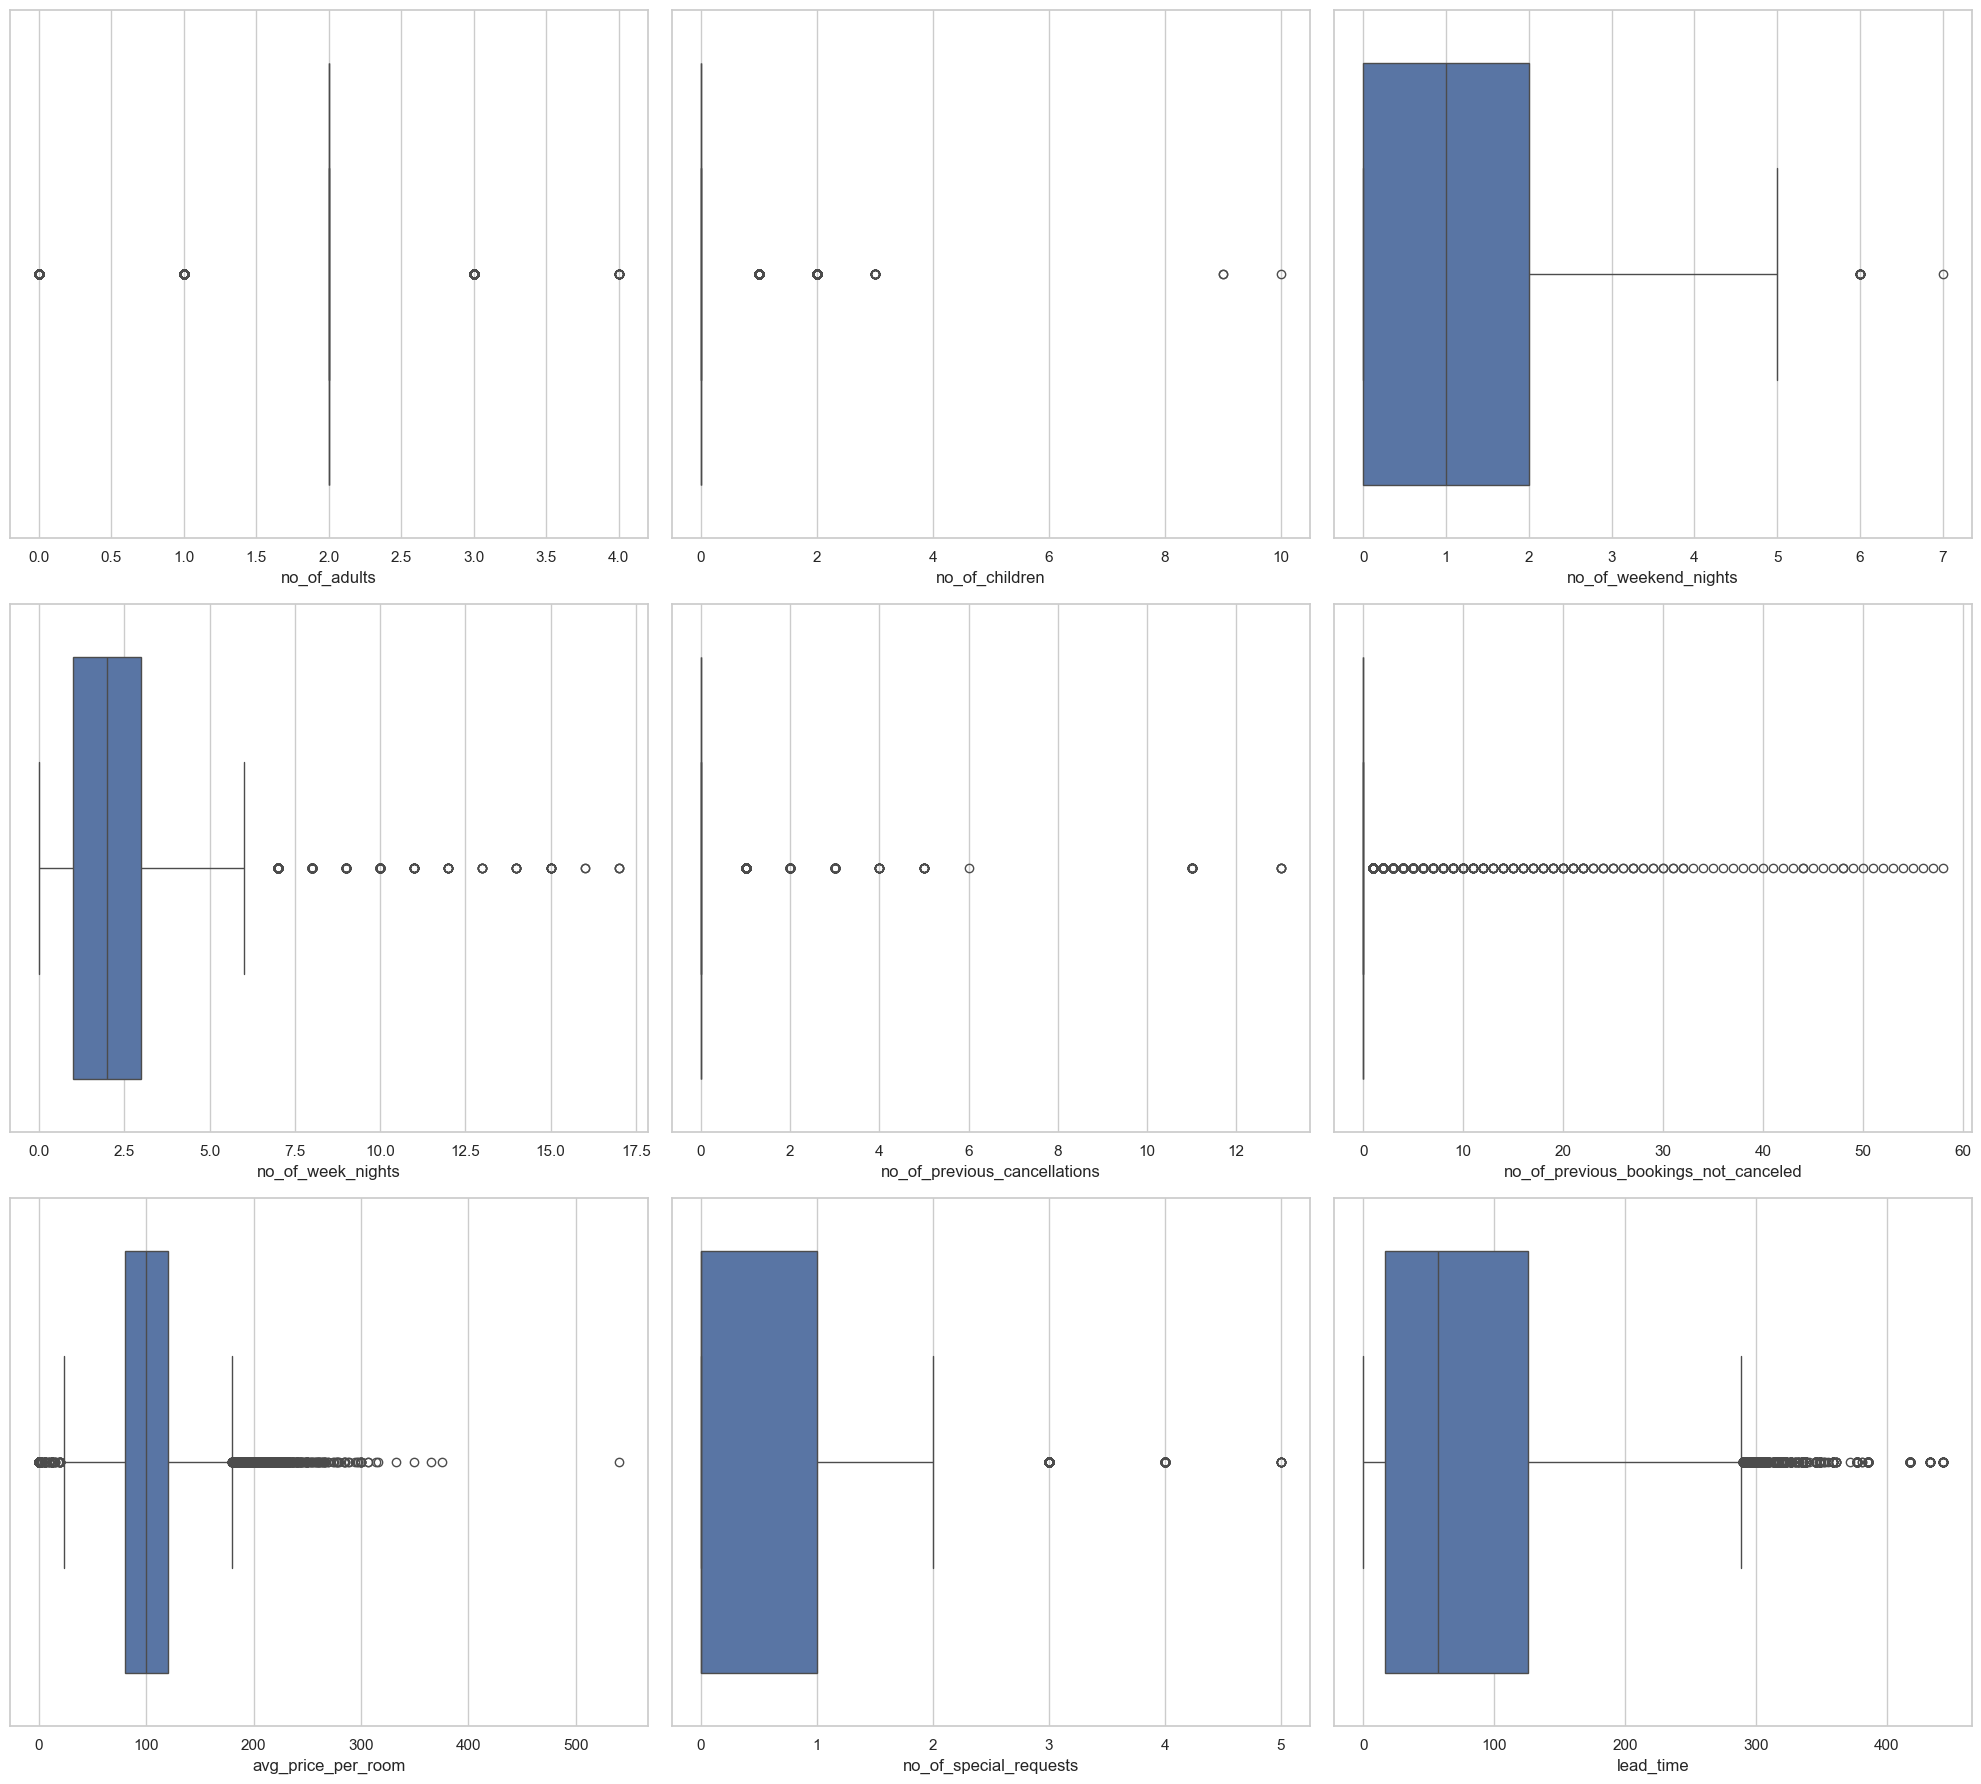

In [13]:
# Features to analyze
features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights',
            'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'lead_time']

# Box Plots
plt.figure(figsize=(20, 18))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)  # Arrange subplots in a grid
    sns.boxplot(x = feature, data=data)
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

**Note:**
1. The boxplots above tell us information on potential outliers as well as other basic descriptive measures such as mean and interquartile range. To view the distribution and skewness in a clearer way, we can use another plot such as the histogram.

**Prompt:**
<div class="alert alert-block alert-info">
Let's visualise the distribution of these numerical features as well.
</div>

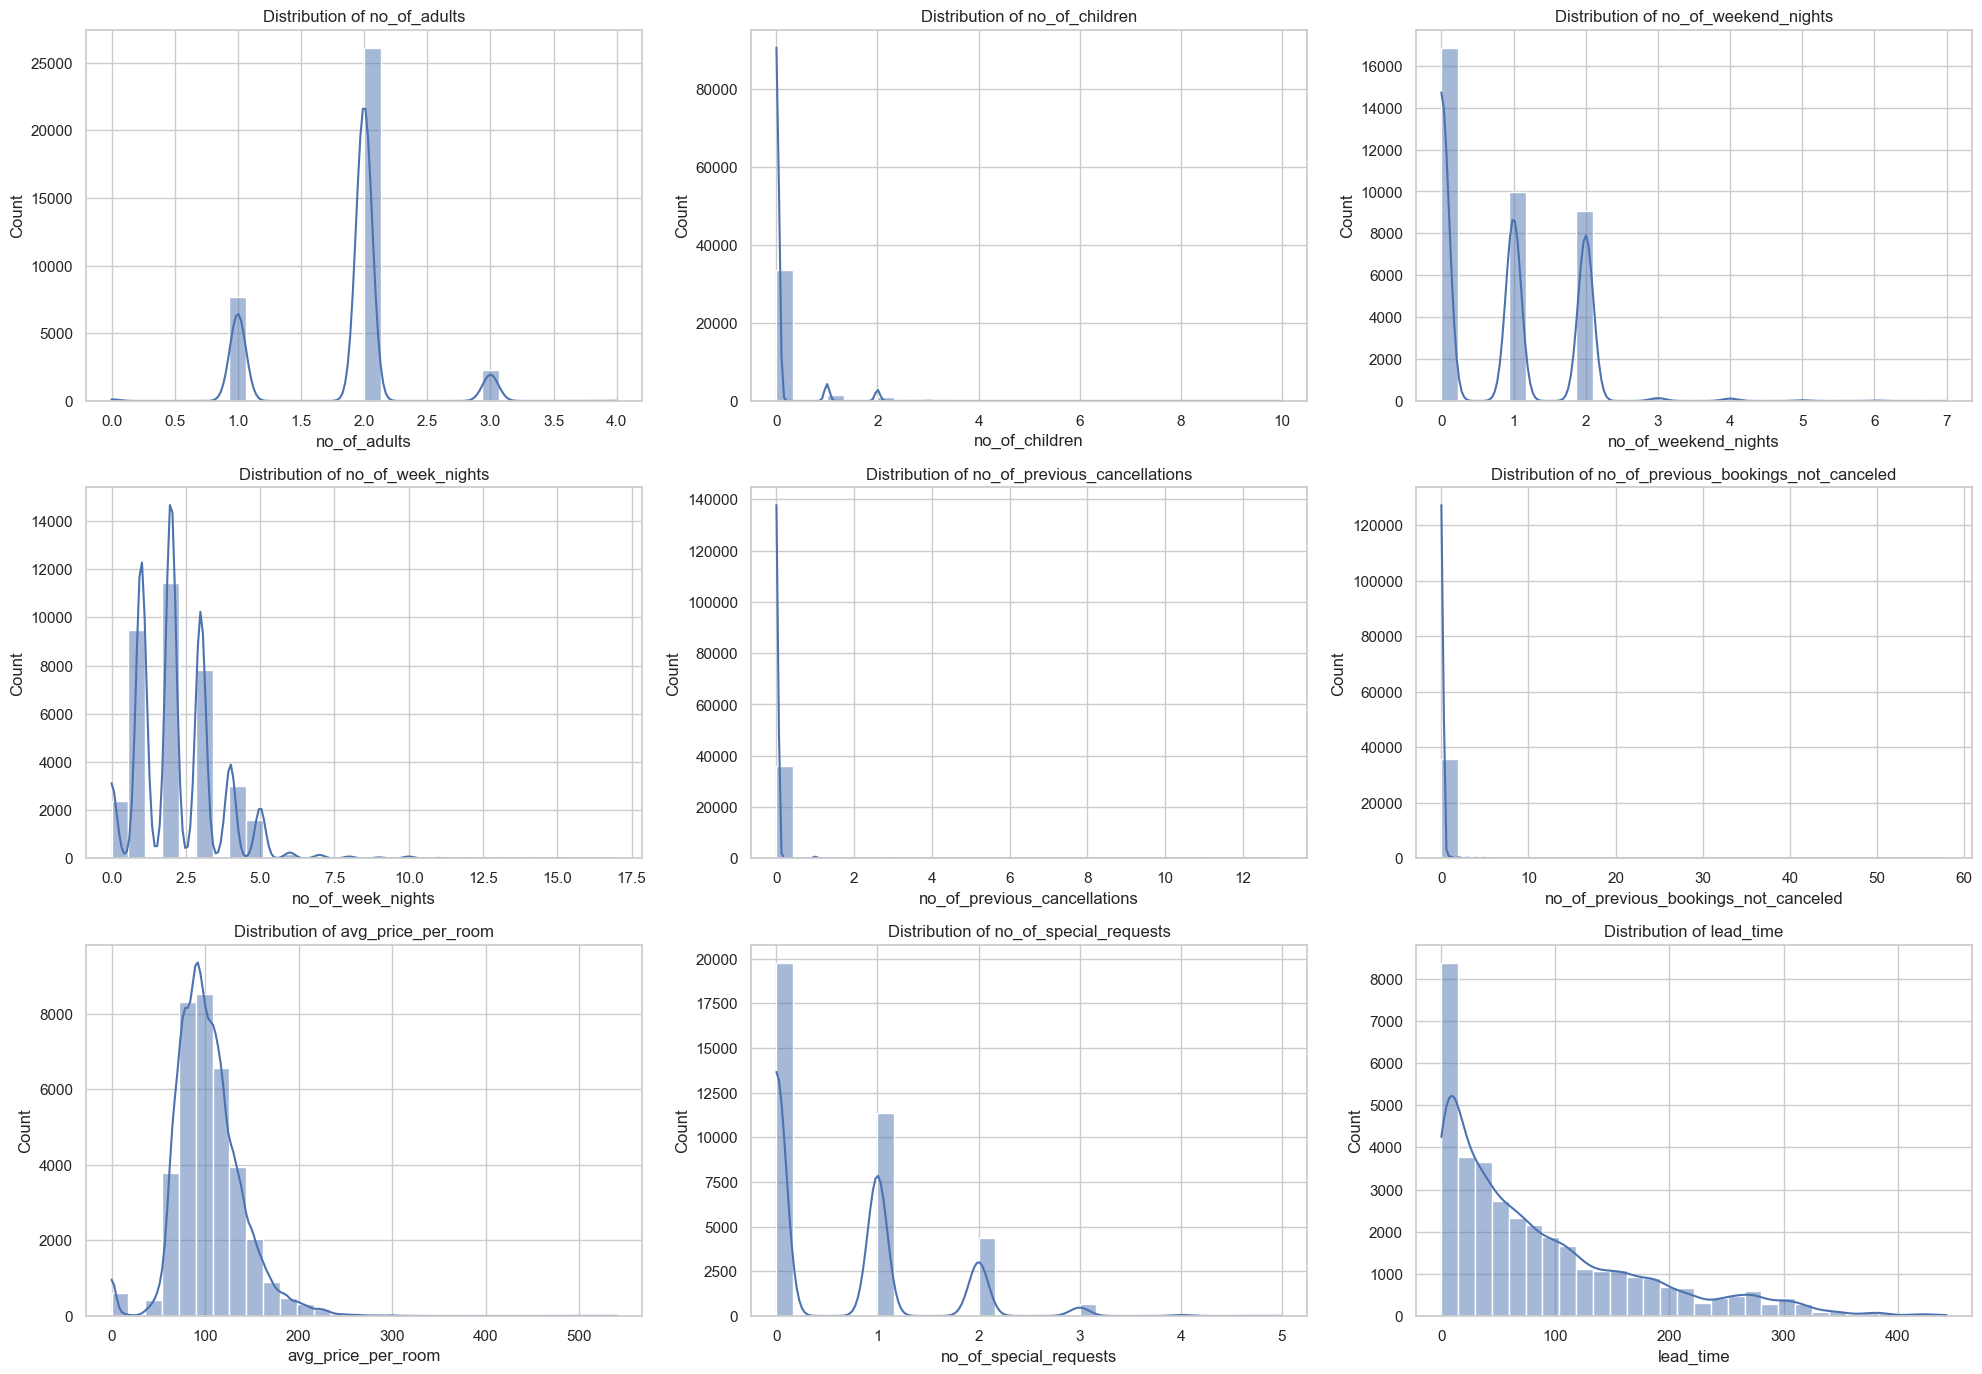

In [14]:
# Defining the figure size for the subplots
plt.figure(figsize=(20, 18))

# Plotting distributions of numerical features
for index, col in enumerate(features, 1):
    plt.subplot(4, 3, index)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

# Adjusting layout for better readability
plt.tight_layout()
plt.show()

**Note:**
1. Here, we observe that most of the distributions are right-skewed, especially `avg_price_per_room` and `lead_time`.
2. Upon further observation, we notice that these two variables contain records where the values are 0, which invite deeper investigation.


**Note:**
<div class="alert alert-warning">

1. Initially, Gemini gave the following line plot to visualise some of the features above. While the code runs, it is certainly not the best choice to visualise these features. Thus, iterations need to be done to prompt for a more suitable plot specific to the feature.

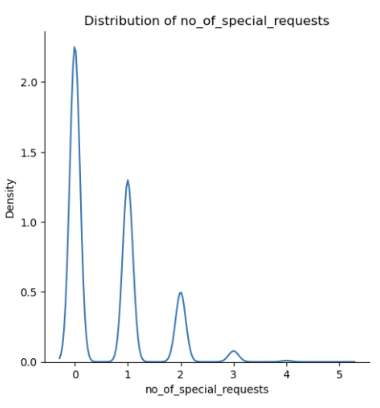

</div>

In [15]:
data['avg_price_per_room'].describe()

count    36275.000000
mean       103.423539
std         35.089424
min          0.000000
25%         80.300000
50%         99.450000
75%        120.000000
max        540.000000
Name: avg_price_per_room, dtype: float64

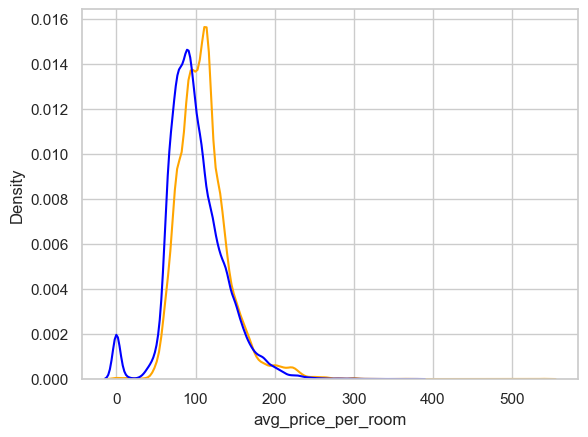

In [16]:
sns.kdeplot(data=data[data['booking_status'] == 'Canceled'], x='avg_price_per_room', color='orange')
sns.kdeplot(data=data[data['booking_status'] == 'Not_Canceled'], x='avg_price_per_room', color='blue');

**Prompt:**
<div class="alert alert-block alert-info">

The kdeplot for `avg_price_per_room` between canceled and not_canceled almost overlaps. Also, when `avg_price_per_room` is 0, what does that mean?

</div>

**Note:**
<div class="alert alert-warning">

The LLM is not able to catch and understand this potentially odd scenario where the `avg_price_per_room` is 0. This means that we have to manually investigate and prompt the LLM for further clarification.

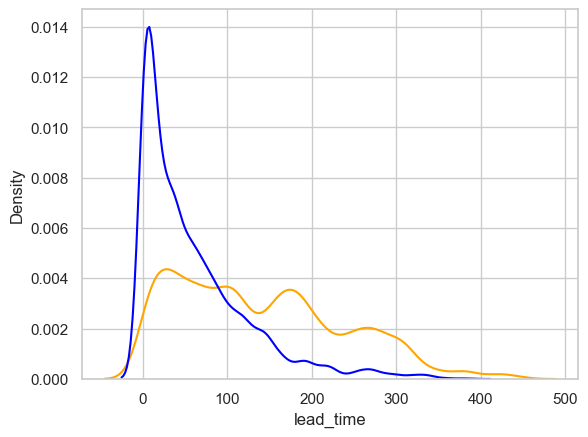

In [17]:
sns.kdeplot(data=data[data['booking_status'] == 'Canceled'], x='lead_time', color='orange')
sns.kdeplot(data=data[data['booking_status'] == 'Not_Canceled'], x='lead_time', color='blue');

In [18]:
(data
 [data['avg_price_per_room'] <= 0]
 .booking_status
 .value_counts()
 )

booking_status
Not_Canceled    539
Canceled          6
Name: count, dtype: int64

In [19]:
(data
 [data['lead_time'] <= 0]
 .booking_status
 .value_counts()
 )

booking_status
Not_Canceled    1229
Canceled          68
Name: count, dtype: int64

In [20]:
zero_price_bookings = data[data['avg_price_per_room'] == 0]
zero_price_bookings

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,lead_time_z_score
63,INN00064,1,0,0,1,Meal Plan 1,0,Room_Type 1,2,2017,9,10,Complementary,0,0,0,0.0,1,Not_Canceled,-0.968613
145,INN00146,1,0,0,2,Meal Plan 1,0,Room_Type 1,13,2018,6,1,Complementary,1,3,5,0.0,1,Not_Canceled,-0.840601
209,INN00210,1,0,0,0,Meal Plan 1,0,Room_Type 1,4,2018,2,27,Complementary,0,0,0,0.0,1,Not_Canceled,-0.945338
266,INN00267,1,0,0,2,Meal Plan 1,0,Room_Type 1,1,2017,8,12,Complementary,1,0,1,0.0,1,Not_Canceled,-0.980250
267,INN00268,1,0,2,1,Meal Plan 1,0,Room_Type 1,4,2017,8,23,Complementary,0,0,0,0.0,1,Not_Canceled,-0.945338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35983,INN35984,1,0,0,1,Meal Plan 1,0,Room_Type 7,0,2018,6,7,Complementary,1,4,17,0.0,1,Not_Canceled,-0.991888
36080,INN36081,1,0,1,1,Meal Plan 1,0,Room_Type 7,0,2018,3,21,Complementary,1,3,15,0.0,1,Not_Canceled,-0.991888
36114,INN36115,1,0,0,1,Meal Plan 1,0,Room_Type 1,1,2018,3,2,Online,0,0,0,0.0,0,Not_Canceled,-0.980250
36217,INN36218,2,0,2,1,Meal Plan 1,0,Room_Type 2,3,2017,8,9,Online,0,0,0,0.0,2,Not_Canceled,-0.956976


**Note:**
1. We attempted to investigate potential reasons on why these 2 features contain the value 0 from the data source but unfortunately, we are unable to find sufficient explanation or any possible explanation from the data.
2. Hence, to move forward, we conclude that for cases where `lead_time = 0`, it is very likely that this represents a "walk-in" scenario where booking has not been done in advance. Moreover, for cases where `avg_price_per_room = 0`, it is very likely that this represents a "promotional offer" in the form of free room experience to attract more customers.
3. We decide to then flag this data points by creating a new additional flag feature.
4. Unfortunately, since we cannot upload the entire dataset to Gemini, we only provide Gemini with the first 20 rows of data. This could be the reason why Gemini never raise the potential issue of having `lead_time = 0` and `avg_price_per_room = 0`. As for ChatGPT, the LLM was unable to identify this potential issue and was only able to give a general explanation that there were anomalies and outliers in general.

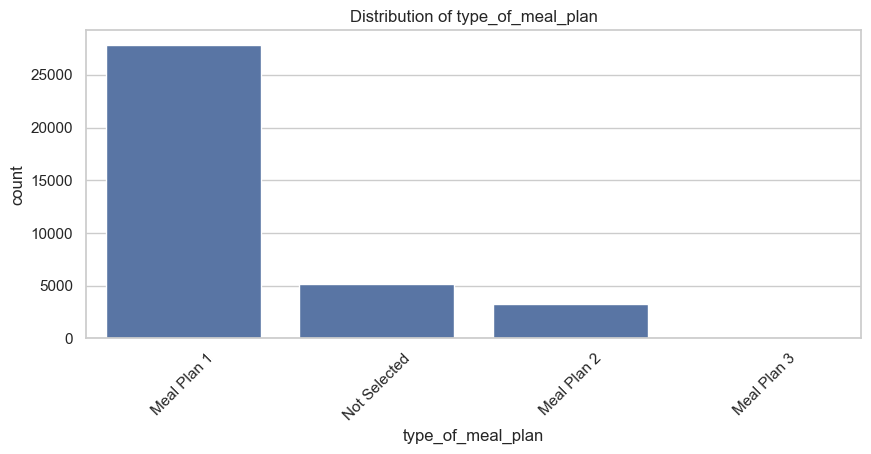

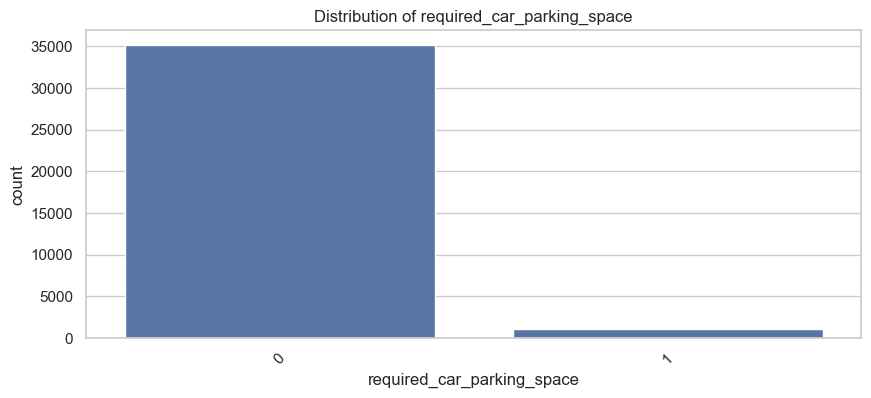

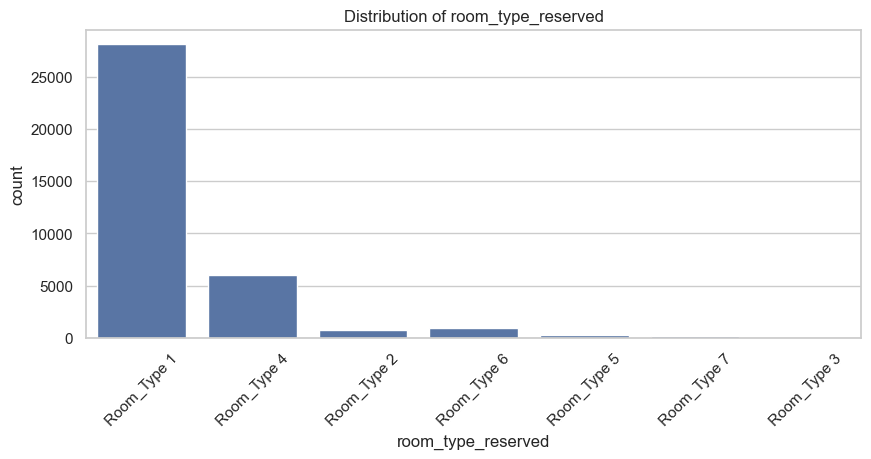

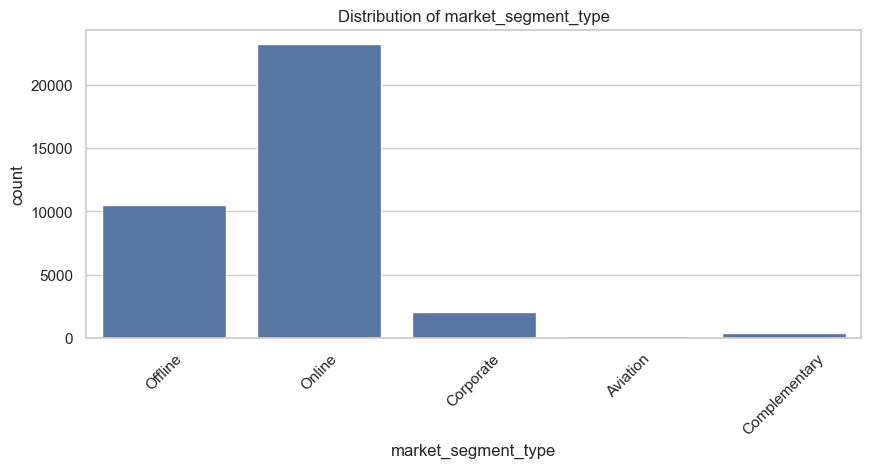

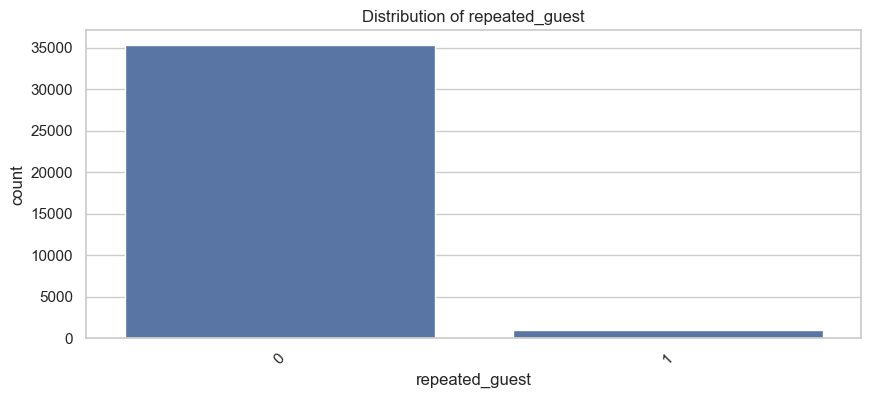

In [21]:
# For categorical variables, we'll display their distribution separately to avoid cluttering the numerical distribution visuals.
categorical_cols = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
                    'market_segment_type', 'repeated_guest']

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, data=data)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

**Note:**
1. Notice that there for these categorical features, we observe low cardinality. However, some values have very few sample sizes which could potentially be a problem when performing train-test splitting at a later stage. Moreover, values with very few sample sizes could not have enough discriminating power to build a robust predictive model.
2. To keep in view this matter, we have a few options such as lumping the values with small sample sizes into the value "Other". For `type_of_meal_plan`, we could even go futher to reduce this to a 0 or 1 problem (Meal or No Meal).

### Bivariate Analysis between Features and Target

**Prompt:**
<div class="alert alert-block alert-info">

Next, please perform bivariate analysis to understand the relationships between features and target variable `booking_status` using appropriate visualisation technique.

</div>

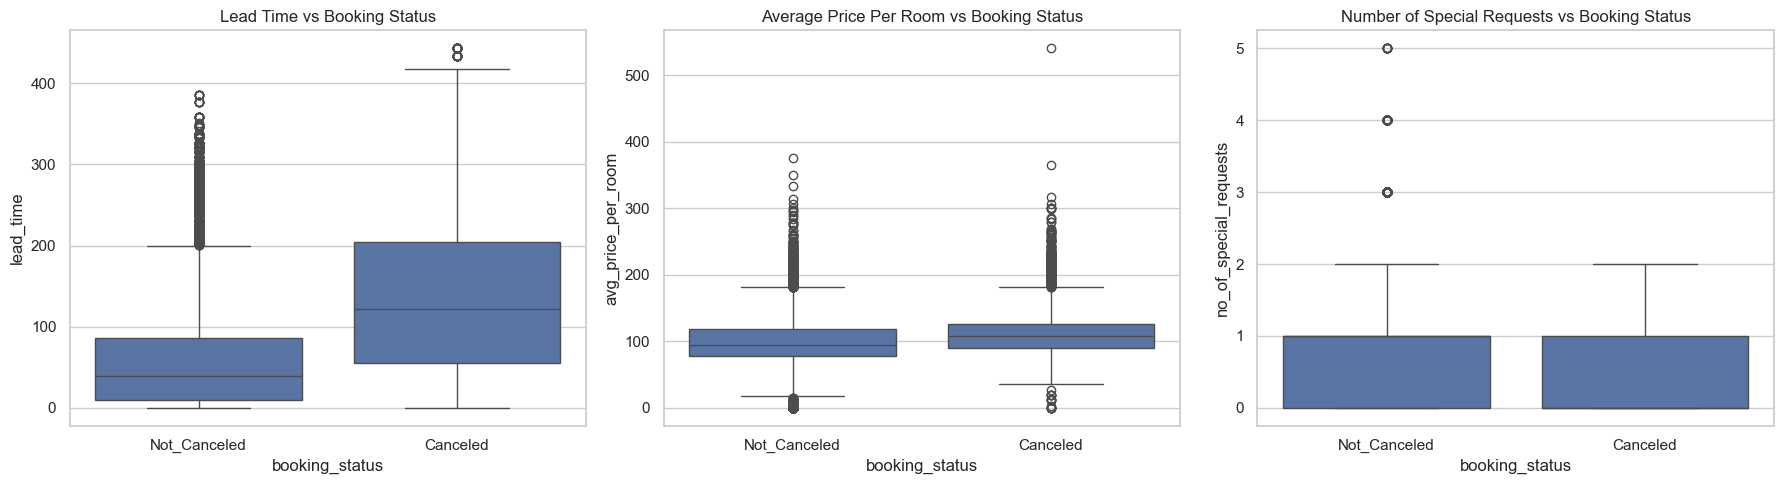

In [22]:
# For the bivariate analysis, we'll look at a few key relationships:
# 1. The relationship between lead time and booking status
# 2. The relationship between average price per room and booking status
# 3. The relationship between number of special requests and booking status

# We will use box plots for numerical vs categorical comparison and count plots for categorical relationships

plt.figure(figsize=(18, 5))

# Lead time vs Booking Status
plt.subplot(1, 3, 1)
sns.boxplot(x='booking_status', y='lead_time', data=data)
plt.title('Lead Time vs Booking Status')

# Average price per room vs Booking Status
plt.subplot(1, 3, 2)
sns.boxplot(x='booking_status', y='avg_price_per_room', data=data)
plt.title('Average Price Per Room vs Booking Status')

# Number of special requests vs Booking Status
plt.subplot(1, 3, 3)
sns.boxplot(x='booking_status', y='no_of_special_requests', data=data)
plt.title('Number of Special Requests vs Booking Status')

plt.tight_layout()
plt.show()

**Prompt:**
<div class="alert alert-block alert-info">
Next, please perform bivariate analysis to understand the relationships between the features using appropriate visualisation technique.
</div>

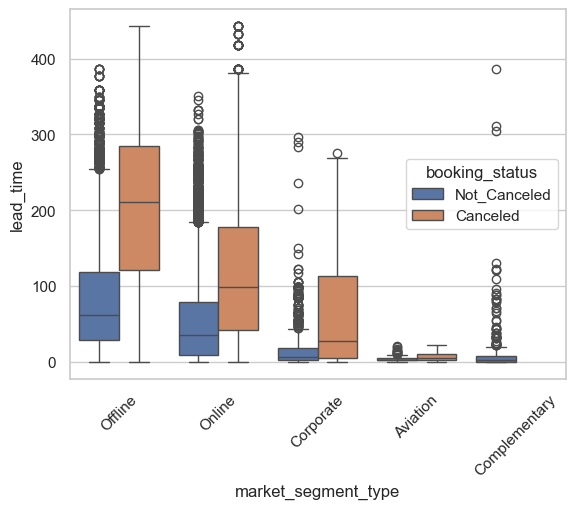

In [23]:
sns.boxplot(x='market_segment_type', y='lead_time', hue='booking_status', data=data)
plt.xticks(rotation=45)
plt.show()

**Note:**
1. Here, we observe that the average `lead_time` for corporate and aviation are the lowest relative to the other market segment.
2. Meanwhile, it seems that the online market segment has the highest cases where booking is done at least 6 months in advance.

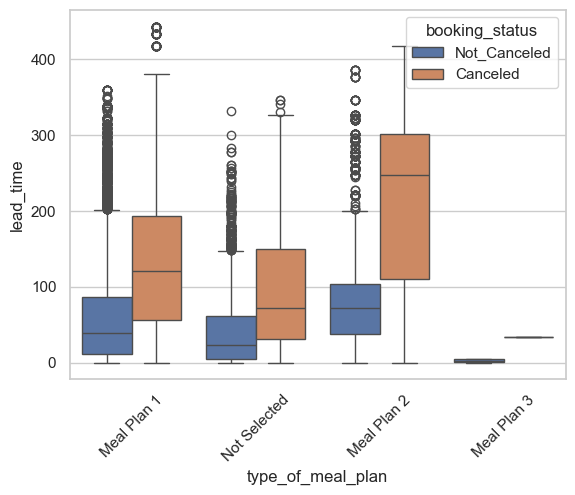

In [24]:
sns.boxplot(x='type_of_meal_plan', y='lead_time', hue='booking_status', data=data)
plt.xticks(rotation=45)
plt.show()

**Note:**
1. Those who opt for Meal Plan 2 tend to have longer `lead_time` on average.
2. Meanwhile those who do not select any meal plan tend to have shorter `lead_time` on average. Perhaps this is because the trip was arranged with a lack of preparation.

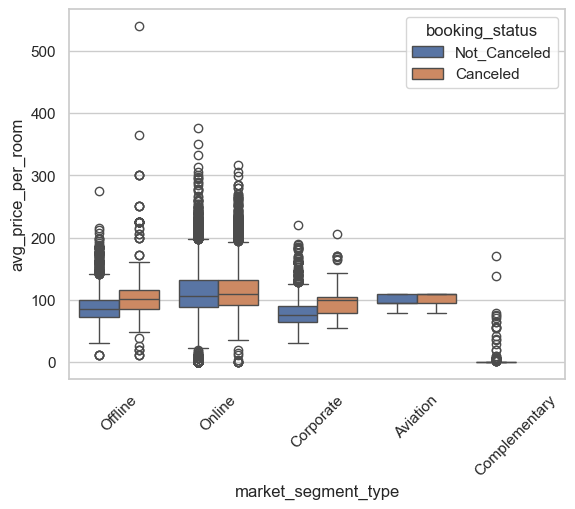

In [25]:
sns.boxplot(x='market_segment_type', y='avg_price_per_room', hue='booking_status', data=data)
plt.xticks(rotation=45)
plt.show()

**Note:**
1. `avg_price_per_room` for corporate `market_segment_type` is lower on average in comparison to the other `market_segment_type`. This could be because purchase was done in bulk and as such, the hotel is able to offer rooms at a cheaper rate.
2. Online `market_segment_type` has the highest variability as seen from the number of outliers. This could be because of the dynamic pricing implementation based on demand and supply principle that applies to customer who purchase online.
3. Complementary `market_segment_type`seems to have the lowest median and extremely short range or inter-quartile range, which may be contributable to its low counts. Also, with its box-plot being all congested to near 0, complementary bookings might be promotional hotel stays given out for free-of-charge or allowing upgrading of rooms at a discount.

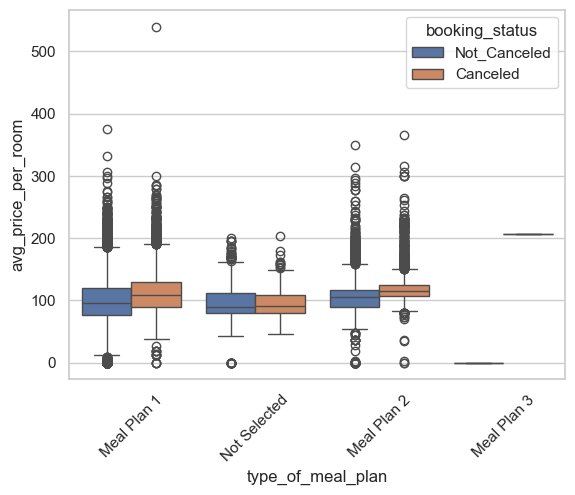

In [26]:
sns.boxplot(x='type_of_meal_plan', y='avg_price_per_room', hue='booking_status', data=data)
plt.xticks(rotation=45)
plt.show()

**Note:**
1. We observe that those who do not select `type_of_meal_plan` tend to have a lower `avg_price_per_room` on average.

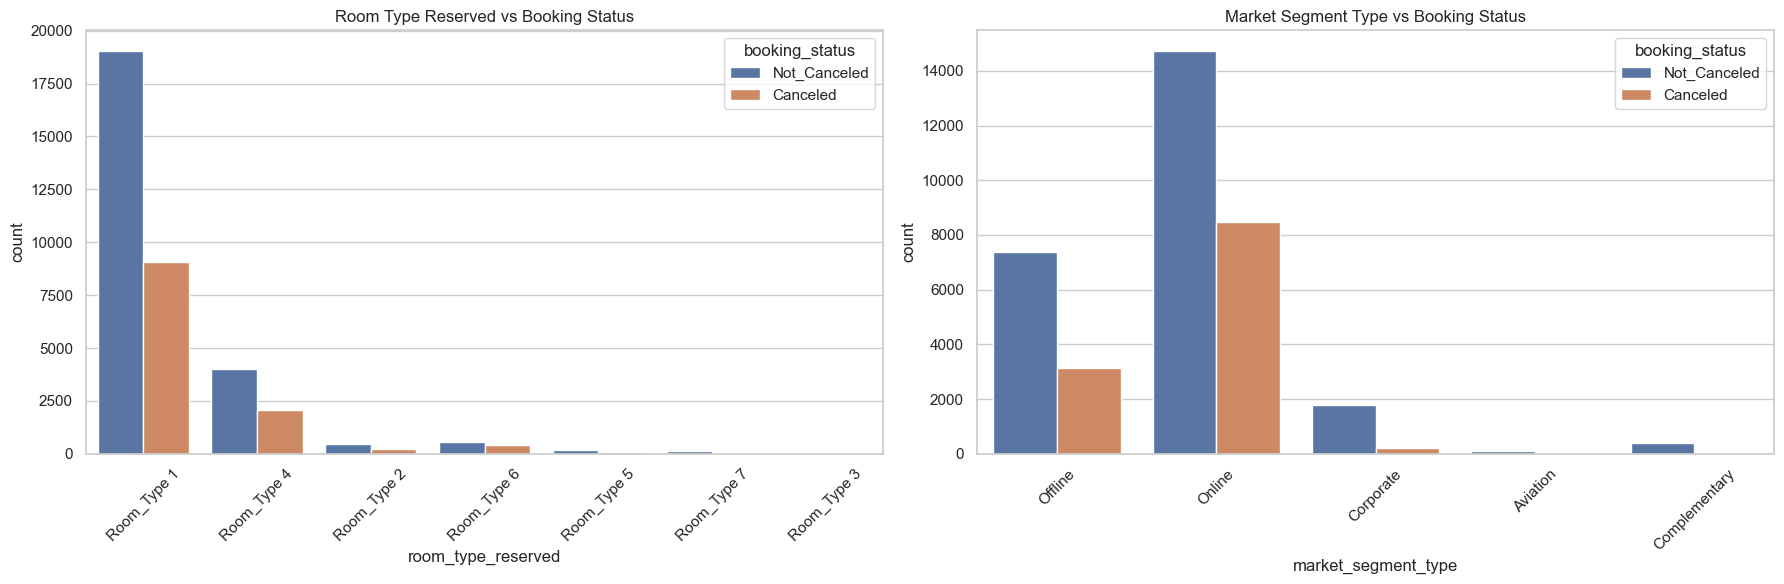

In [27]:
plt.figure(figsize=(18, 6))

# Exploring the relationship between room type reserved and booking status through a count plot
plt.subplot(1, 2, 1)
sns.countplot(x='room_type_reserved', hue='booking_status', data=data)
plt.title('Room Type Reserved vs Booking Status')
plt.xticks(rotation=45)

# Exploring the relationship between market segment type and booking status
plt.subplot(1, 2, 2)
sns.countplot(x='market_segment_type', hue='booking_status', data=data)
plt.title('Market Segment Type vs Booking Status')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

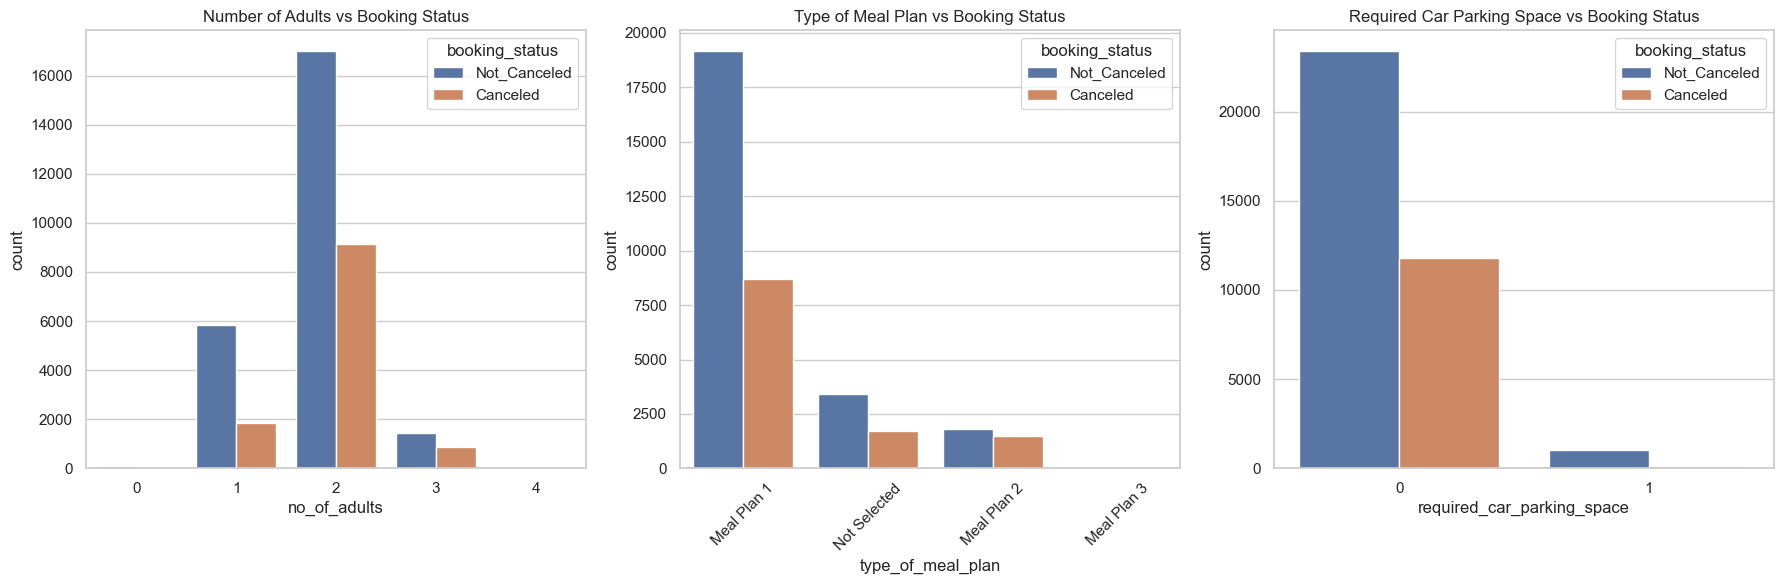

In [28]:
# Adjusting figure size for better visualization
plt.figure(figsize=(18, 6))

# Number of Adults vs Booking Status
plt.subplot(1, 3, 1)
sns.countplot(x='no_of_adults', hue='booking_status', data=data)
plt.title('Number of Adults vs Booking Status')

# Type of Meal Plan vs Booking Status
plt.subplot(1, 3, 2)
sns.countplot(x='type_of_meal_plan', hue='booking_status', data=data)
plt.title('Type of Meal Plan vs Booking Status')
plt.xticks(rotation=45)

# Required Car Parking Space vs Booking Status
plt.subplot(1, 3, 3)
sns.countplot(x='required_car_parking_space', hue='booking_status', data=data)
plt.title('Required Car Parking Space vs Booking Status')

plt.tight_layout()
plt.show()

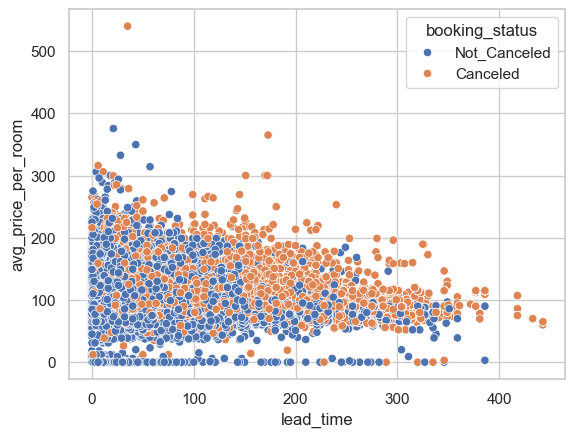

In [29]:
sns.scatterplot(x='lead_time', y='avg_price_per_room', data=data, hue='booking_status')
plt.show()

**Note**:
1. It seems that `lead_time` above 5-6 months tend to have more cancellation cases as compared to lower value of `lead_time`. This could be because trip planning done more than 6 months period tend to be merely a rough planning that is very likely to change in the future.

In [30]:
(data
 .loc[lambda df_: df_['lead_time'].ge(150)]
 ['booking_status']
 .value_counts(dropna=False)
 )

booking_status
Canceled        5239
Not_Canceled    2158
Name: count, dtype: int64

**Note:**
1. Here, we observe that for booking done more than 5 months in advance, there are more cancellation cases relative to non-cancellation cases.

Cancellation proportion for lead time >= 30 days: 0.4218
Cancellation proportion for lead time >= 60 days: 0.4905
Cancellation proportion for lead time >= 90 days: 0.5639
Cancellation proportion for lead time >= 120 days: 0.6254
Cancellation proportion for lead time >= 150 days: 0.7083
Cancellation proportion for lead time >= 180 days: 0.7369


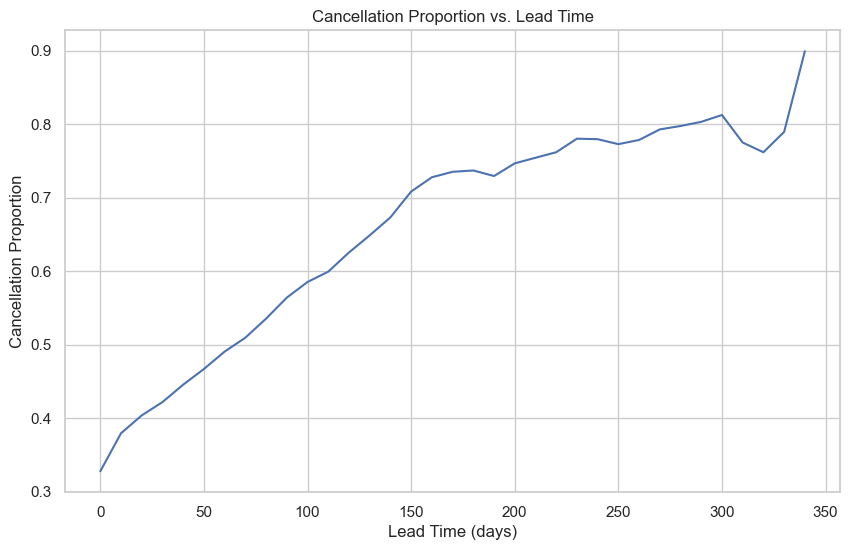

In [31]:
def calculate_cancel_proportion(data, lead_time_cutoff):
    filtered_data = data[data['lead_time'] >= lead_time_cutoff]
    n_canceled = filtered_data['booking_status'].value_counts().get('Canceled', 0)
    n_not_canceled = filtered_data['booking_status'].value_counts().get('Not_Canceled', 0)
    return n_canceled / (n_canceled + n_not_canceled)

# Calculate for various cutoffs
for cutoff in [30, 60, 90, 120, 150, 180]:
    proportion = calculate_cancel_proportion(data.copy(), cutoff)
    print(f"Cancellation proportion for lead time >= {cutoff} days: {proportion:.4f}")

# Line plot
cancel_proportions = []
cutoffs = range(0, 350, 10)  # Adjust range as needed
for cutoff in cutoffs:
    cancel_proportions.append(calculate_cancel_proportion(data.copy(), cutoff))

plt.figure(figsize=(10,6))
plt.plot(cutoffs, cancel_proportions)
plt.xlabel('Lead Time (days)')
plt.ylabel('Cancellation Proportion')
plt.title('Cancellation Proportion vs. Lead Time')
plt.show()

**Note:**
1. Further analysis to view the cancelation cases as lead time increases from 1 month to 6 months.

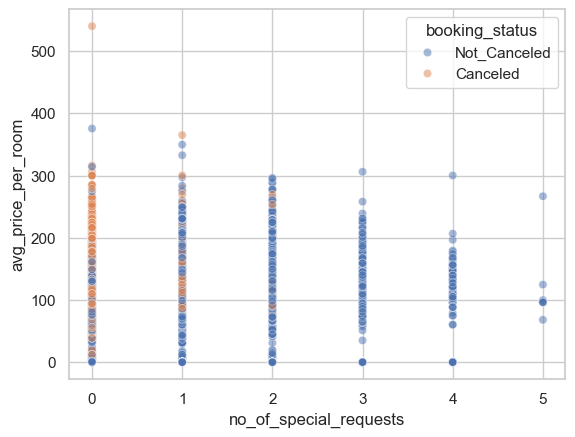

In [32]:
sns.scatterplot(x='no_of_special_requests', y='avg_price_per_room', data=data, hue='booking_status', alpha=0.5)
plt.show()

**Note:**
1. Here, we observe that for higher number of special requests, we have lesser cancellation cases. This could be because the customers who make special requests are more invested in their bookings.

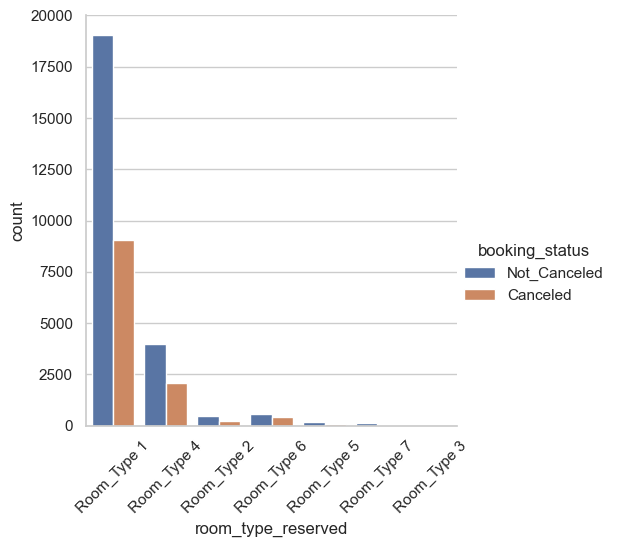

In [33]:
sns.catplot(x='room_type_reserved', kind='count', hue='booking_status', data=data)
plt.xticks(rotation=45)
plt.show()

**Note:**
1. A majority of the room reservation is concentrated between room type 1 and 4.

### Dealing with datetime

**Prompt:**
<div class="alert alert-block alert-info">
Next, let’s visualise the count of arrival based on arrival date using a line plot.
</div>

**Note:**
<div class="alert alert-warning">

1. The LLMs recommended the following line of code

`data['arrival_date'] = pd.to_datetime(data['arrival_date'])`, which does not work because the arrival_date is just an integer ranging from 1 to 31. The conclusion is that even though we have provided the LLMs with the first 20 rows of data, it is not able to capture this datetime intricacy quite well.

2. A few round of iterations are needed in order to get the LLMs to convert datetime to the expected format.

3. While GPT4 is able to recognise this issue better than the other LLMs, it still struggles to properly convert the data types to the expected output that can be fed as the argument to the plot.

</div>

/var/folders/zx/x3_2llcj0tqd7f6y6p1wdbhr0000gn/T/ipykernel_66081/3597623137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['arrival_datetime'] = pd.to_datetime(data['arrival_year'].astype(str) + '-' + data['arrival_month'].astype(str) + '-' + data['arrival_date'].astype(str))


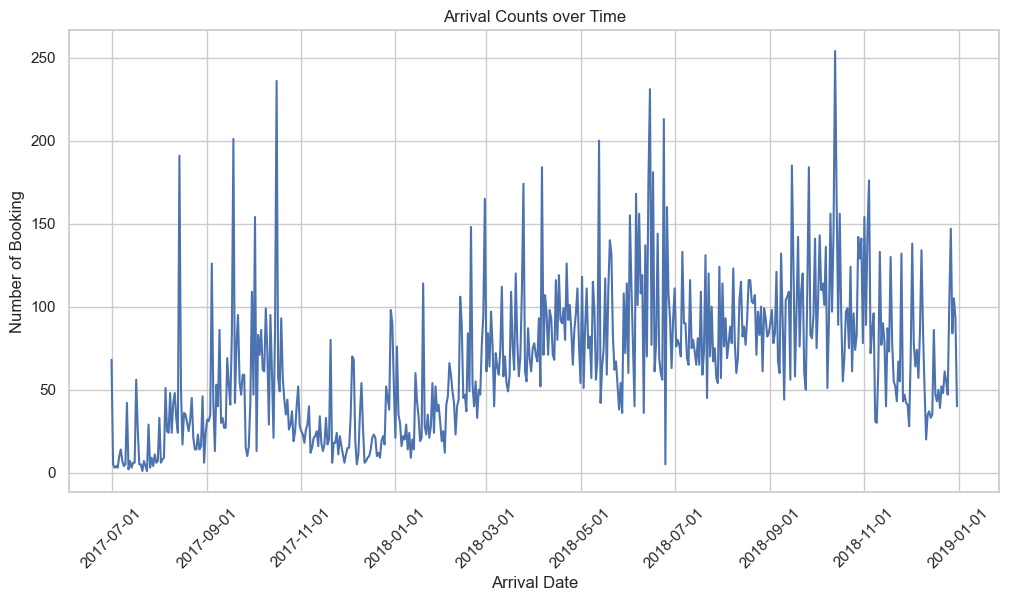

In [34]:
# Create a datetime column for better aggregation

# Create a boolean mask to find the problematic rows with wrong leap year
error_mask = (data['arrival_month'] == 2) & (data['arrival_date'] == 29) & (data['arrival_year'] == 2018)

data = data[~error_mask]

# Create a new column by combining year, month and date

data['arrival_datetime'] = pd.to_datetime(data['arrival_year'].astype(str) + '-' + data['arrival_month'].astype(str) + '-' + data['arrival_date'].astype(str))

arrival_counts = data.groupby('arrival_datetime')['Booking_ID'].count()

plt.figure(figsize=(12, 6))
plt.plot(arrival_counts.index, arrival_counts.values)

# Formatting
plt.xlabel('Arrival Date')
plt.ylabel('Number of Booking')
plt.title('Arrival Counts over Time')

# Rotate x-axis labels for readability if needed
plt.xticks(rotation=45)

# Improve x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

**Note:**
1. Here, we visualise the number of booking made across the entire period from mid 2017 to end 2018.
2. Fluctuations observed albeit an overall increasing trend.
3. Note that Gemini provides code that runs with warning. This is likely because it does not keep up-to-date with the most recent documentation update. Instead, it is likely trained on codes that are written using the older version of documentation.

In [35]:
# For monthly counts
arrival_counts = (data
                  .groupby(by=[pd.Grouper(key='arrival_datetime', freq='ME'), 'booking_status'])
                  # .resample('M', on='arrival_datetime')
                  ['Booking_ID']
                  .count()
                  )
arrival_counts

arrival_datetime  booking_status
2017-07-31        Canceled           243
                  Not_Canceled       120
2017-08-31        Canceled           185
                  Not_Canceled       829
2017-09-30        Canceled           182
                  Not_Canceled      1467
2017-10-31        Canceled           302
                  Not_Canceled      1611
2017-11-30        Canceled            27
                  Not_Canceled       620
2017-12-31        Canceled            22
                  Not_Canceled       906
2018-01-31        Canceled            24
                  Not_Canceled       990
2018-02-28        Canceled           423
                  Not_Canceled      1244
2018-03-31        Canceled           700
                  Not_Canceled      1658
2018-04-30        Canceled           995
                  Not_Canceled      1741
2018-05-31        Canceled           948
                  Not_Canceled      1650
2018-06-30        Canceled          1291
                  Not_Ca

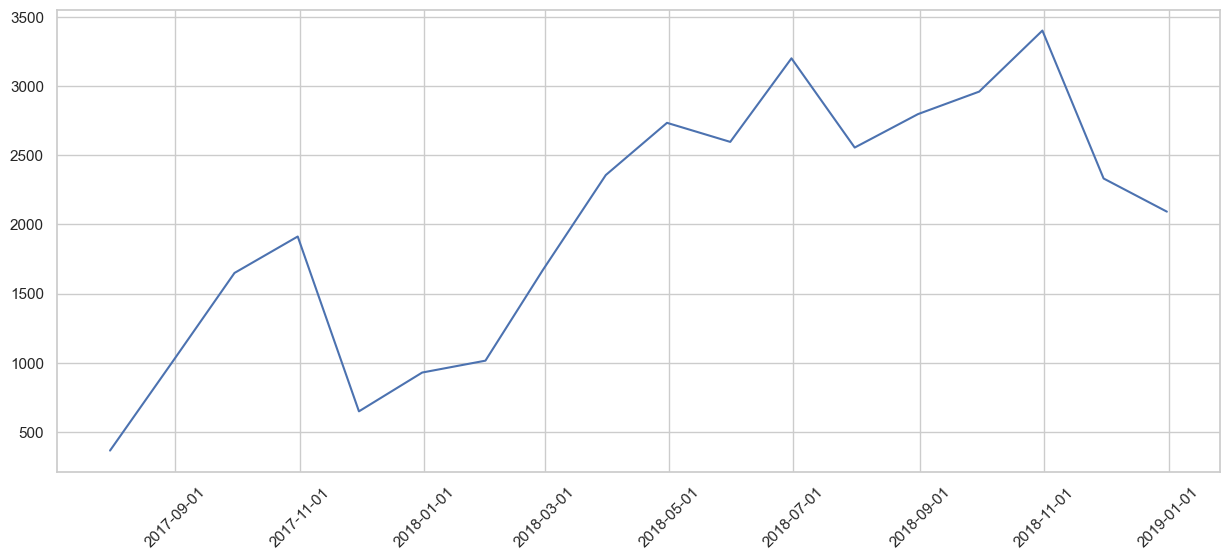

In [36]:
# Rotate x-axis labels for readability if needed
fig, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation=45)

# Improve x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(arrival_counts.unstack().index, arrival_counts.unstack().assign(Booking_Count=lambda df_: df_['Canceled'] + df_['Not_Canceled']).drop(columns=['Canceled', 'Not_Canceled']));

**Note:**
1. Here, we observed number of bookings made on a monthly basis.

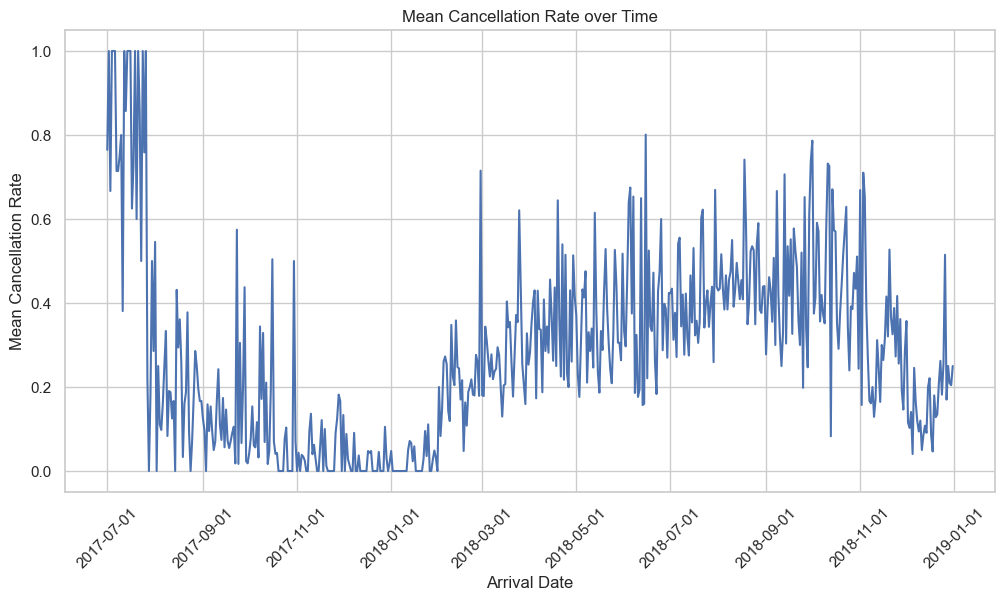

In [37]:
# Assuming you already have the 'arrival_datetime' column created

# Group by arrival datetime and calculate mean cancellation rate
# data['cancelled'] = (data['booking_status'] == 'Canceled').astype(int)  # Convert bookings status to 0 or 1
data = data.assign(cancelled=np.where(data['booking_status'] == 'Canceled', 1, 0))
grouped_data = data.groupby('arrival_datetime')['cancelled'].mean()

plt.figure(figsize=(12, 6))
plt.plot(grouped_data.index, grouped_data.values)

# Formatting
plt.xlabel('Arrival Date')
plt.ylabel('Mean Cancellation Rate')
plt.title('Mean Cancellation Rate over Time')

# Rotate x-axis labels for readability if needed
plt.xticks(rotation=45)

# Improve x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

**Note:**
1. Here, we observe mean cancellation rate over time.
2. Note that Gemini provides code that runs with warning. This is likely because it does not keep up-to-date with the most recent documentation update. Instead, it is likely trained on codes that are written using the older version of documentation.

**Prompt:**
<div class="alert alert-block alert-info">
Now, let's extract some additional features from the arrival_datetime feature, then visualise these against other features and target for a more in-depth exploratory data analysis.
</div>

In [38]:
data = data.assign(arrival_weekday=data['arrival_datetime'].dt.day_name(),
                   arrival_week_of_year=lambda df_: df_['arrival_datetime'].dt.isocalendar().week,
                   arrival_quarter=lambda df_: df_['arrival_datetime'].dt.quarter,
                   is_weekend=lambda df_: df_['arrival_weekday'].isin(['Saturday', 'Sunday']))

**Note:**
1. Note that Gemini provides code that runs with warning. This is likely because it does not keep up-to-date with the most recent documentation update. Instead, it is likely trained on codes that are written using the older version of documentation.

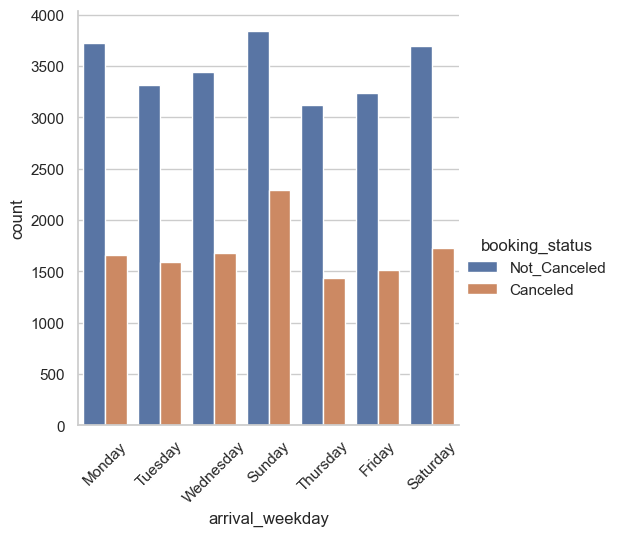

In [39]:
sns.catplot(x='arrival_weekday', kind='count', hue='booking_status', data=data)
plt.xticks(rotation=45)
plt.show()

**Note:**
1. Arrival day of the week does not seem to be predictive of `booking_status` in general, although we observe that there are slightly more cancellation cases on Sunday.

In [40]:
(data
 .groupby(by=['arrival_week_of_year', 'booking_status'])
 .agg({'Booking_ID': 'count'})
 .unstack(level=1)
 .reset_index(drop=True))

Booking_ID             
booking_status   Canceled Not_Canceled
0                      11          249
1                       6          164
2                       3          279
3                      11          240
4                      27          188
5                      71          252
6                      99          358
7                      74          352
8                     233          410
9                     128          369
10                    129          345
11                    256          417
12                    131          355
13                    240          405
14                    201          412
15                    276          410
16                    224          413
17                    194          380
18                    276          401
19                    222          385
20                    166          321
21                    239          418
22                    289          478
23                    432          475
24                    269          412
25                    288          417
26                    296          365
27                    242          372
28                    325          342
29                    237          369
30                    330          420
31                    318          524
32                    411          661
33                    339          487
34                    270          527
35                    338          687
36                    361          703
37                    360          879
38                    411          633
39                    436          877
40                    531          893
41                    438          792
42                    298          577
43                    513          600
44                    117          544
45                    179          549
46                    186          475
47                    101          416
48                     76          763
49                     45          345
50                     56          400
51                    169          855

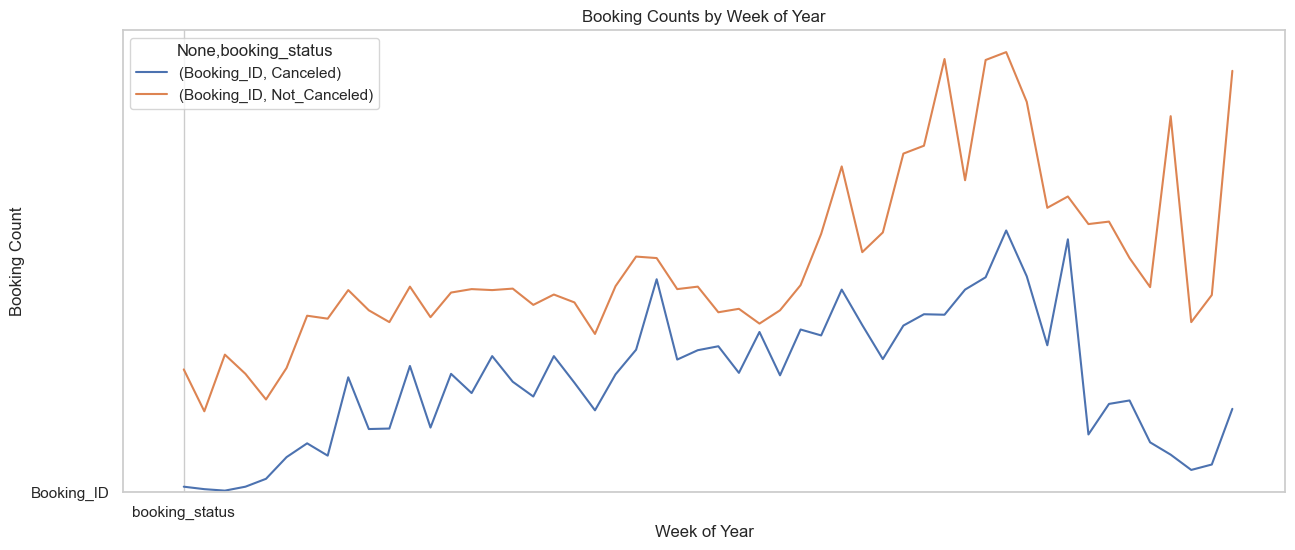

In [41]:
fig, ax = plt.subplots(figsize=(15, 6))
(data
 .groupby(by=['arrival_week_of_year', 'booking_status'])
 .agg({'Booking_ID': 'count'})
 .unstack(level=1)
 .reset_index(drop=True)
 .plot(ax=ax, xlabel='Week of Year', ylabel='Booking Count', title='Booking Counts by Week of Year')
 .bar(x='booking_status', height='Booking_ID')
 );

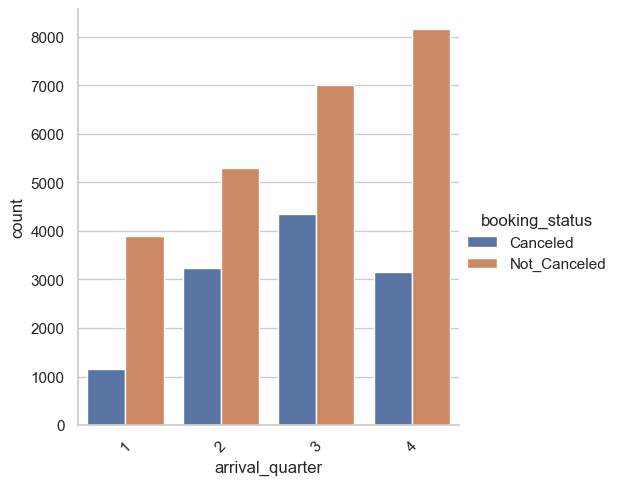

In [42]:
sns.catplot(x='arrival_quarter', kind='count', hue='booking_status', data=data)
plt.xticks(rotation=45)
plt.show()

**Note:**
1. More arrival observed on the 4th cases, with cancellation rate lower than that of the 2nd and 3rd quarter. This could be because demand is high during the holiday period thus customers are less likely to cancel their booking else risking going on a trip without accommodation.

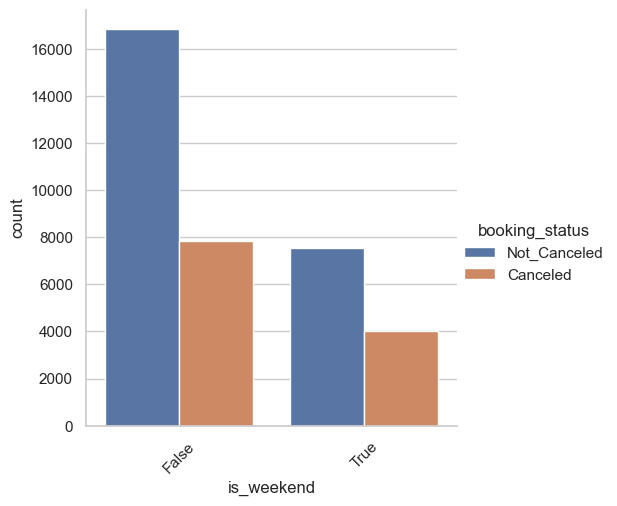

In [43]:
sns.catplot(x='is_weekend', kind='count', hue='booking_status', data=data)
plt.xticks(rotation=45)
plt.show()

**Note:**
1. Whether the arrival day is a a weekend or not does not seem to be predictive of booking cancellations in general.

### Correlation Matrix

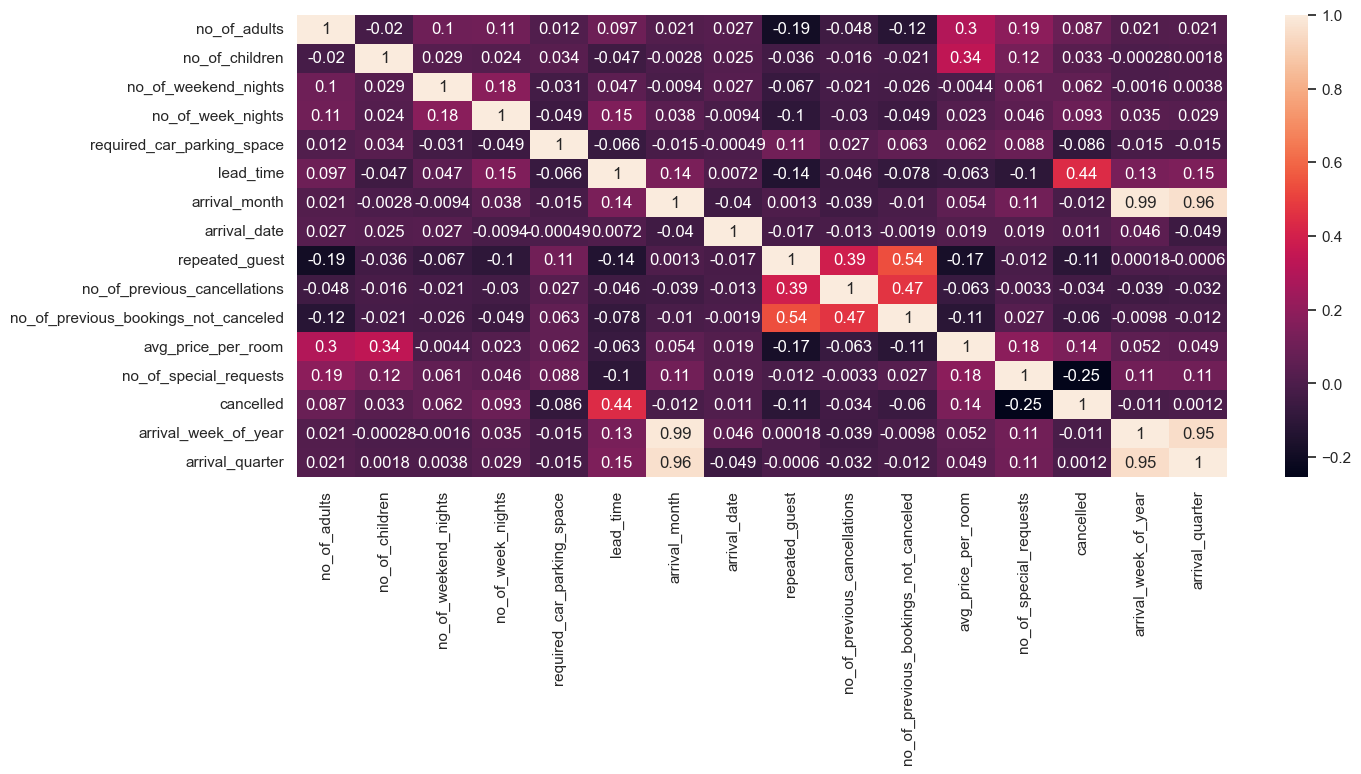

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))
corr_matrix = data.select_dtypes('number').drop(columns=['arrival_year', 'lead_time_z_score']).corr()
sns.heatmap(corr_matrix, annot=True, ax=ax)
plt.show()

**Note:**
1. `lead_time` and `no_of_special_requests` seem to have moderate linear correlation with `booking_status`.
2. We need to consider that the moderate level of linear correlation of `no_of_previous_cancellations` and `no_of_previous_bookings_not_canceled` with `repeated_guests` is likely due to the fact that you cant be a repeated guest if you have not done any previous bookings or cancellations before.
3. The correlation between `arrival_week_of_year`, `arrival_quarter` and `arrival_month` should not be considered since time or dates are in continous running order, which would contribute to high correlation.